In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import commons
import textwrap
import math

In [2]:
# load data and ratings about open-source projects

features = set()
scores = set()
data = []
score_weights = {}

def process_used_score_value(used_value, row, score_weights):
    score_type = used_value['score']['type']
    if used_value['isNotApplicable']:
        row[score_type] = 'N/A'
    else:
        row[score_type] = used_value['value']
    if score_type not in score_weights:
        score_weights[score_type] = used_value['weight']
    elif score_weights[score_type] != used_value['weight']:
        raise Exception('Oops! Weights do not match!')

def process_vulnerability_value(used_value, row):
    row['# of vulnerabilities'] = len(used_value['vulnerabilities']['entries'])
    row['# of unpatched vulnerabilities'] = 0
    row['# of patched vulnerabilities'] = 0
    row['# of vulnerabilities without introduced date'] = 0
    row['# of vulnerabilities without fixed date'] = 0
    for entry in used_value['vulnerabilities']['entries']:
        if entry['resolution'] == 'UNPATCHED':
            row['# of unpatched vulnerabilities'] = row['# of unpatched vulnerabilities'] + 1
        elif entry['resolution'] == 'PATCHED':
            row['# of patched vulnerabilities'] = row['# of patched vulnerabilities'] + 1
        if entry['introduced'] is None:
            row['# of vulnerabilities without introduced date'] = row['# of vulnerabilities without introduced date'] + 1
        if entry['fixed'] is None:
            row['# of vulnerabilities without fixed date'] = row['# of vulnerabilities without fixed date'] + 1
        
def process_sub_scores(score_value, row, score_weights):
    for used_value in score_value['usedValues']:
        if used_value['type'] == 'ScoreValue':
            scores.add(used_value['score']['type'])
            process_used_score_value(used_value, row, score_weights)
            process_sub_scores(used_value, row, score_weights)
            continue
        
        feature = used_value['feature']['name']
        features.add(feature)
          
        if used_value['type'] == 'UnknownValue':
            row[feature] = 'unknown'
        elif used_value['type'] == 'VulnerabilitiesValue':
            process_vulnerability_value(used_value, row)
                
        elif used_value['type'] == 'IntegerValue':
            row[feature] = used_value['number']
        elif used_value['type'] == 'BooleanValue':
            row[feature] = used_value['flag']
        elif used_value['type'] == 'DateValue':
            row[feature] = used_value['date']
        elif used_value['type'] == 'LanguagesValue':
            row[feature] = used_value['languages']['elements']
        elif used_value['type'] == 'PackageManagersValue':
            row[feature] = used_value['packageManagers']['packageManagers']
        elif used_value['type'] == 'LgtmGradeValue':
            row[feature] = used_value['value']
        else:
            raise Exception('Unknown value type: ' + used_value['type'])

with open('../../../../../docs/oss/security/github_projects.json') as json_file:
    json_data = json.load(json_file)
    for json_project_data in json_data:
        row = {}
        row['URL'] = json_project_data['url']
        rating_value = json_project_data['ratingValue']
        if rating_value is None:
            continue
            
        row['Label'] = rating_value['label'][1]
        
        score_value = json_project_data['ratingValue']['scoreValue']
        row['Score'] = score_value['value']
        row['Confidence'] = score_value['confidence']
        
        process_sub_scores(score_value, row, score_weights)
        
        data.append(row)
            
        
project_data = pd.DataFrame(data)
project_data.fillna('unknown', inplace = True)
project_data

,URL,Label,Score,Confidence,UnpatchedVulnerabilitiesScore,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date,...,If an open-source project uses AddressSanitizer,If an open-source project uses MemorySanitizer,If an open-source project uses UndefinedBehaviorSanitizer,ProjectPopularityScore,Number of stars for a GitHub repository,Number of watchers for a GitHub repository,ProjectSecurityAwarenessScore,If an open-source project has a security policy,If an open-source project has a security team,If a project uses signed commits
0,https://github.com/FasterXML/aalto-xml,BAD,3.914183,9.433247,10.0,0,0,0,0,0,...,False,False,False,0.282667,226,17,3.0,True,unknown,False
1,https://github.com/FasterXML/jackson,BAD,3.053193,9.123633,10.0,47,0,47,47,0,...,False,False,False,6.671333,5538,340,0.0,False,unknown,False
2,https://github.com/FasterXML/jackson-annotations,BAD,4.071219,9.433247,10.0,0,0,0,0,0,...,False,False,False,1.064000,814,75,3.0,True,unknown,False
3,https://github.com/FasterXML/jackson-core,BAD,4.316396,9.433247,10.0,0,0,0,0,0,...,False,False,False,2.310333,1797,154,3.0,True,unknown,False
4,https://github.com/FasterXML/jackson-databind,BAD,4.496725,9.433247,10.0,43,0,43,43,0,...,False,False,False,3.018000,2488,159,3.0,True,unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,https://github.com/spring-projects/spring-vault,MODERATE,5.121691,9.433247,10.0,0,0,0,0,0,...,False,False,False,0.182000,142,12,2.0,False,unknown,True
405,https://github.com/spring-projects/spring-webflow,BAD,4.685860,9.433247,10.0,0,0,0,0,0,...,False,False,False,0.394000,254,42,0.0,False,unknown,False
406,https://github.com/spring-projects/spring-ws,MODERATE,5.054932,9.433247,10.0,0,0,0,0,0,...,False,False,False,0.412667,206,62,2.0,False,unknown,True
407,https://github.com/spring-projects/spring-xd,BAD,4.287536,9.433247,10.0,0,0,0,0,0,...,False,False,False,0.797667,471,98,0.0,False,unknown,False


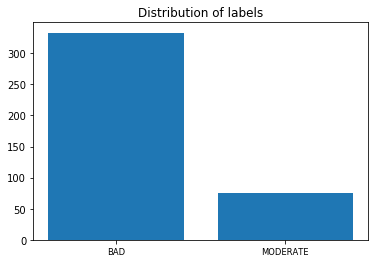

In [3]:
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('Distribution of labels')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


<Figure size 720x720 with 0 Axes>

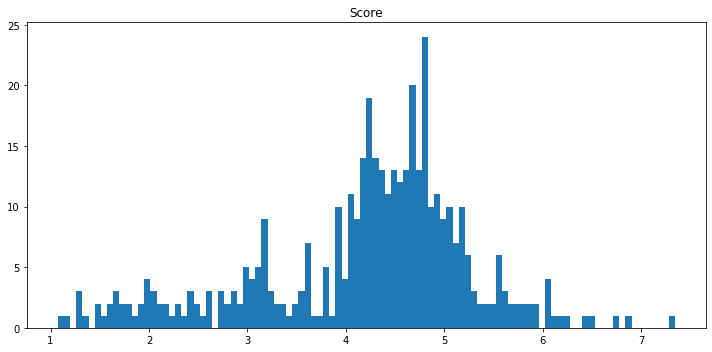

In [4]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Score'
d = df[df[column] != 'N/A']
d = d.loc[:, column]
ax.hist(d, histtype='bar', bins=100)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

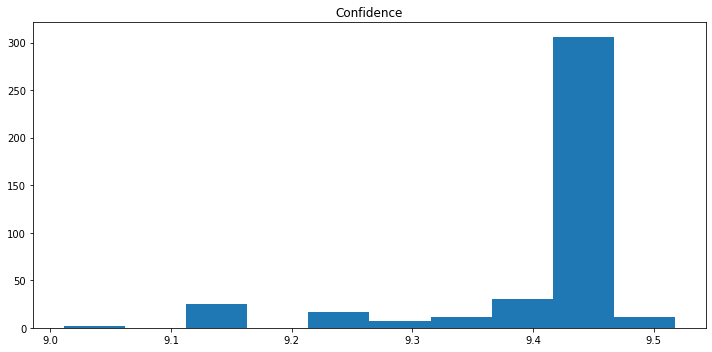

In [5]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Confidence'
d = df[df[column] != 'N/A']
d = d.loc[:, column]
ax.hist(d, histtype='bar', bins='auto')
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

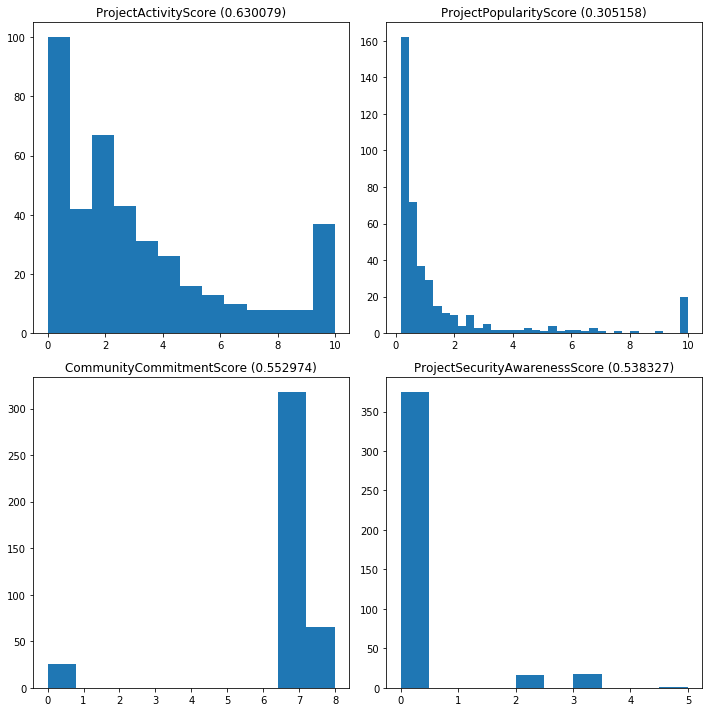

In [6]:
df = project_data[['ProjectActivityScore', 'ProjectPopularityScore', 
                   'CommunityCommitmentScore', 'ProjectSecurityAwarenessScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[df[column] != 'N/A']
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

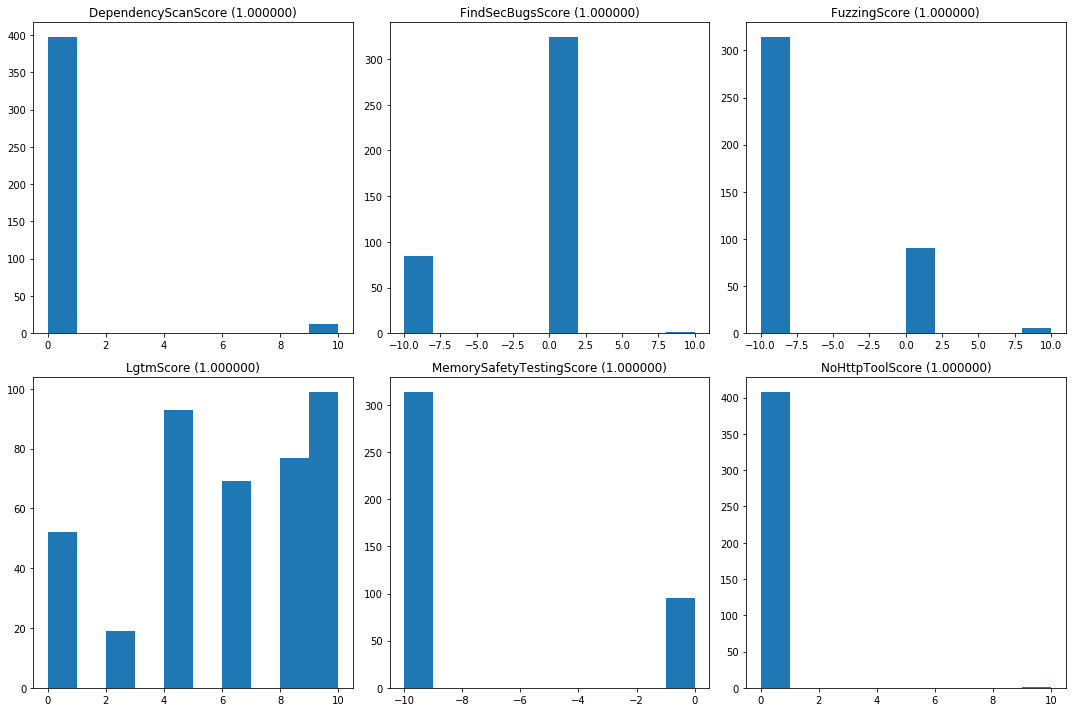

In [7]:
df = project_data[['DependencyScanScore', 'FindSecBugsScore', 'FuzzingScore', 'LgtmScore', 
                   'MemorySafetyTestingScore', 'NoHttpToolScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 3)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df.replace('N/A', -10)
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

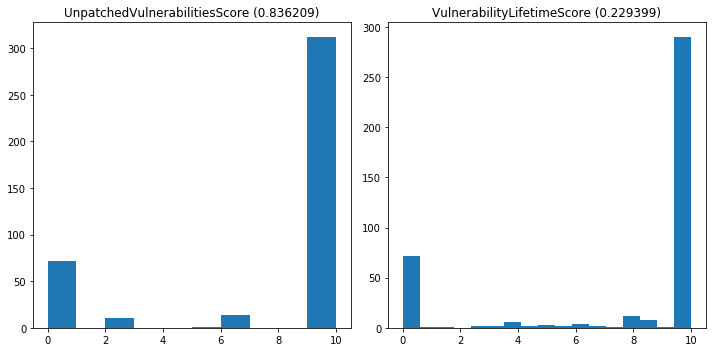

In [8]:
df = project_data[['UnpatchedVulnerabilitiesScore', 'VulnerabilityLifetimeScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(1, 2)
f.set_figwidth(10)
f.set_figheight(5)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[df[column] != 'N/A']
    d = d.iloc[:,idx]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

In [9]:
pd.DataFrame.from_dict(score_weights, orient='index')

,0
UnpatchedVulnerabilitiesScore,0.836209
ProjectActivityScore,0.630079
CommunityCommitmentScore,0.552974
VulnerabilityLifetimeScore,0.229399
ProjectSecurityTestingScore,0.628312
FindSecBugsScore,1.000000
NoHttpToolScore,1.000000
LgtmScore,1.000000
FuzzingScore,1.000000
DependencyScanScore,1.000000


<Figure size 720x720 with 0 Axes>

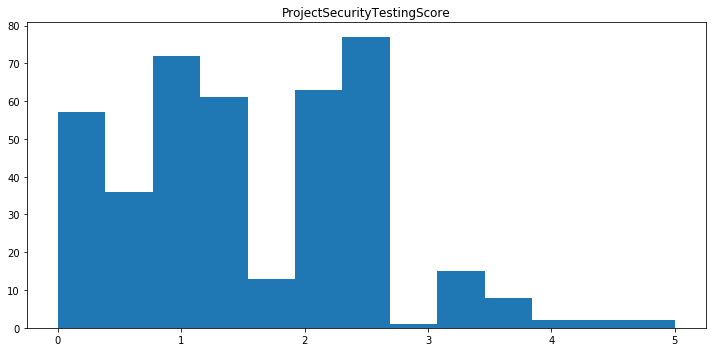

In [10]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'ProjectSecurityTestingScore'
d = df[df[column] != 'N/A']
d = d.loc[:, column]
ax.hist(d, histtype='bar', bins='auto')
ax.set_title(column)
plt.tight_layout()

In [11]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of unpatched vulnerabilities', 
     '# of patched vulnerabilities']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities
25,https://github.com/apache/ant,2468,1405,1063
285,https://github.com/eclipse/che,2246,1226,1020
28,https://github.com/apache/apr,1041,970,71
207,https://github.com/apache/poi,960,734,226
186,https://github.com/apache/nifi,754,586,168
...,...,...,...,...
157,https://github.com/apache/jackrabbit,4,2,2
295,https://github.com/eclipse/egit,4,4,0
127,https://github.com/apache/felix,4,1,3
278,https://github.com/apache/zookeeper,4,1,3


In [12]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of vulnerabilities without introduced date', 
     '# of vulnerabilities without fixed date']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date
25,https://github.com/apache/ant,2468,2468,1405
285,https://github.com/eclipse/che,2246,2246,1226
28,https://github.com/apache/apr,1041,1041,970
207,https://github.com/apache/poi,960,960,734
186,https://github.com/apache/nifi,754,754,586
...,...,...,...,...
157,https://github.com/apache/jackrabbit,4,4,2
295,https://github.com/eclipse/egit,4,4,4
127,https://github.com/apache/felix,4,4,1
278,https://github.com/apache/zookeeper,4,4,1


In [13]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def draw_boolean_hists(df, columns, a):
    a = a.ravel()
    for idx, ax in enumerate(a):
        column = df.columns[idx]
        if column not in columns: continue
        vc = df[column].replace(True, 'Yes').replace(False, 'No').value_counts().to_dict()
        if 'Yes' not in vc: vc['Yes'] = 0
        if 'No' not in vc: vc['No'] = 0
        if 'unknown' not in vc: vc['unknown'] = 0
        rects = ax.bar(vc.keys(), vc.values(), width=0.5)
        autolabel(rects)
        ax.set_title(column)

<Figure size 720x720 with 0 Axes>

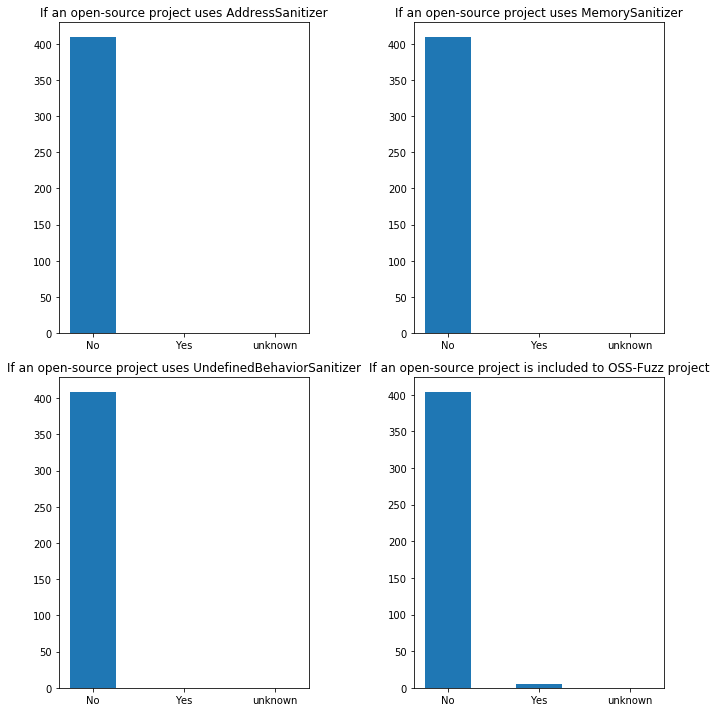

In [14]:
columns = [
    'If an open-source project uses AddressSanitizer', 
    'If an open-source project uses MemorySanitizer',
    'If an open-source project uses UndefinedBehaviorSanitizer',
    'If an open-source project is included to OSS-Fuzz project',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

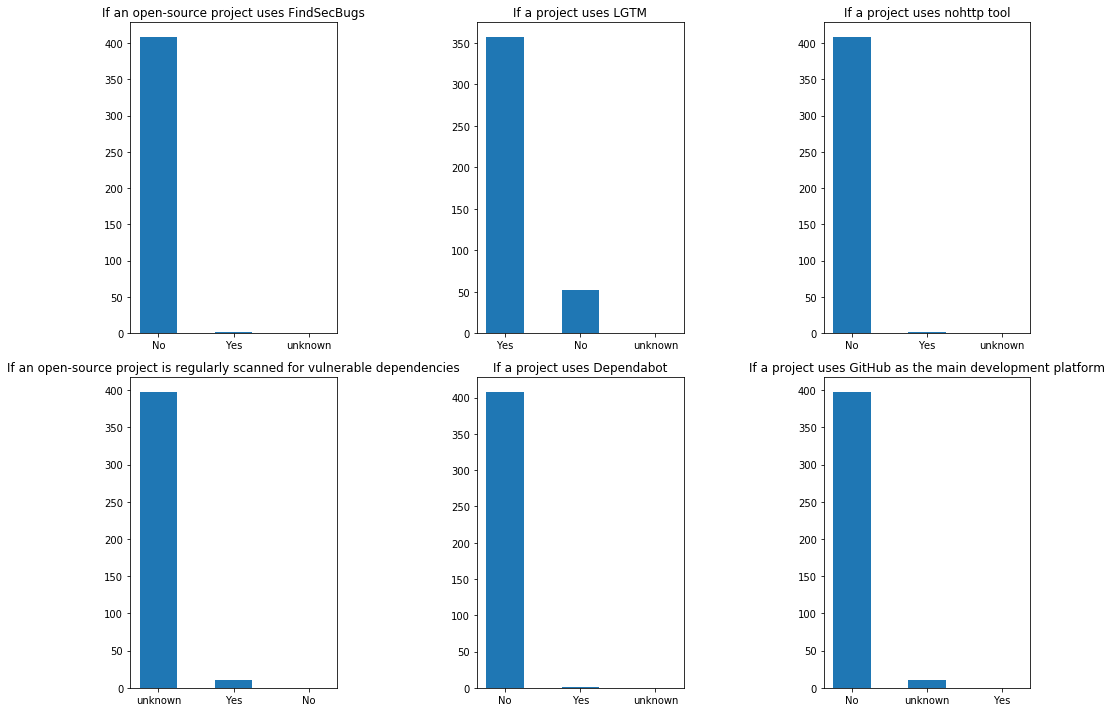

In [15]:
columns = [    
    'If an open-source project uses FindSecBugs',
    'If a project uses LGTM checks for commits',
    'If a project uses nohttp tool',
    'If an open-source project is regularly scanned for vulnerable dependencies',
    'If a project uses Dependabot',
    'If a project uses GitHub as the main development platform',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

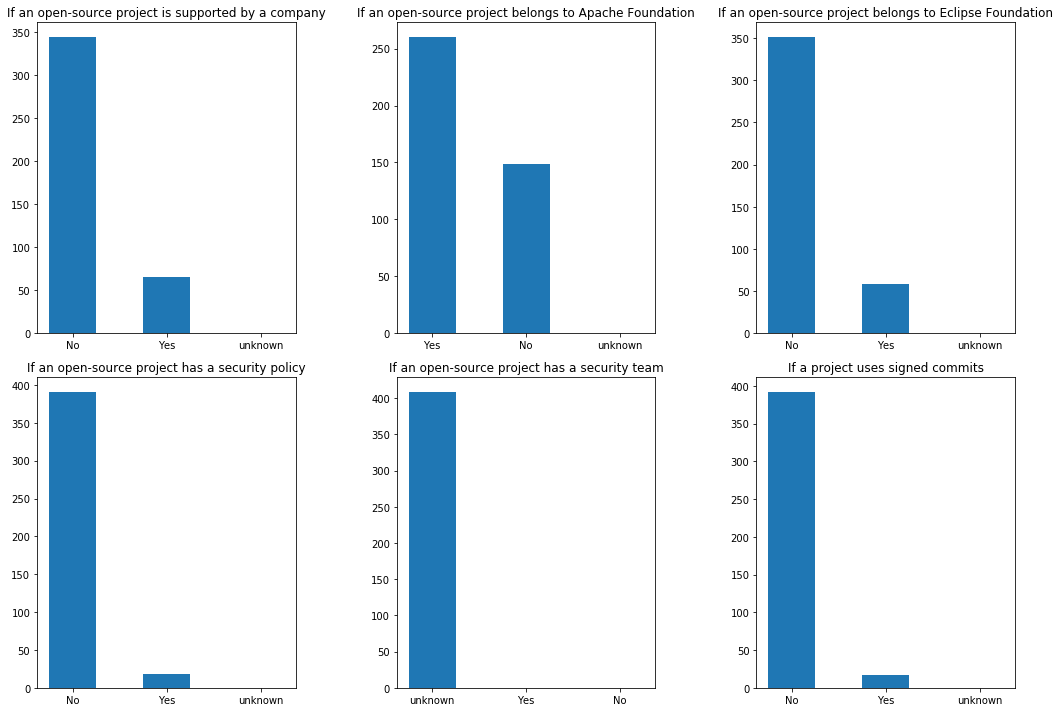

In [16]:
columns = [        
    'If an open-source project is supported by a company',
    'If an open-source project belongs to Apache Foundation',
    'If an open-source project belongs to Eclipse Foundation',
    'If an open-source project has a security policy',
    'If an open-source project has a security team',
    'If a project uses signed commits',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

In [17]:
# Conclusions (May 12th, 2020):
#
# 1. Vulnerability matching doesn't work well, there are a lot of false-positives
#    (for example, see a number of issues for OpenSSL).
#    TODO: Let's see if https://github.com/SAP/fosstars-rating-core/pull/180 impoves it.
#          If it doesn't, we'll need to disable scores that use info about vulnerabilities
#          (UnpatchedVulnerabilitiesScore and VulnerabilityLifetimeScore)
#
# 2. Most of vulnerabilities are considered unpatched. Those are false-positives.
#    TODO: Try to re-work UnpatchedVulnerabilitiesScore.
#          If it doesn't work out, use only the list of unpatched issue.
#
# 3. All vulnerabilities don't have dates when they were introduced.
#    Many vulnerabilities don't have dates when they fixed.
#    The existing dates are estimated by the dates when the issues were published.
#    Then, VulnerabilityLifetimeScore tries to estimate the dates.
#    As a result, the score becomes very unreliable
#    TODO: Try to re-work VulnerabilityLifetimeScore. If it doesn't work out, disable the score.
#
# 4. Both LgtmScore and FindSecBugsScore assess how a project uses static analysis.
#    It's not necessary for a project to use both (or even more tools).
#    The score may be combined to a StaticAnalysisScore.
#    TODO: Introduce StaticAnalysisScore.
#
# 5. The feature for a security team is always unknown.
#    That looks like a bug in the corresponding data provider.
#    TODO: Fix it.
#
# 6. The feature 'If a project uses GitHub as the main development platform' is almost always No.
#    But many of the projects use GitHub for devemopment. This looks like a bug in the data provider.
#    TODO: Fix it.
#          May be caused by https://github.com/SAP/fosstars-rating-core/issues/184
#
# 7. None of the projects use sanitizers. That looks suspicious.
#    TODO: Look into it.
#
# 8. ProjectSecurityTestingScore calculates an average of sub-scores. That may not be fair.
#    TODO: Consider updating ProjectSecurityTestingScore to use weights.
#

In [18]:
bad_ratings_fraction = 0.30
moderate_ratings_fraction = 0.50
good_ratings_fraction = 0.20

if bad_ratings_fraction + moderate_ratings_fraction + good_ratings_fraction != 1:
    raise Exception('Oops!')

n = len(project_data.index)
target_bad_ratings_number = bad_ratings_fraction * n
target_moderate_ratings_number = moderate_ratings_fraction * n
    
moderate_threshold = 0
good_threshold = 0
i = 0
for index, value in project_data['Score'].sort_values().items():
    i = i + 1
    if moderate_threshold == 0 and i > target_bad_ratings_number:
        moderate_threshold = value
        i = 0
    if good_threshold == 0 and i > target_moderate_ratings_number:
        good_threshold = value
        break
        
print('New threshold for MODERATE = {:f}'.format(moderate_threshold))
print('New threshold for GOOD     = {:f}'.format(good_threshold))

New threshold for MODERATE = 4.037856
New threshold for GOOD     = 4.962568


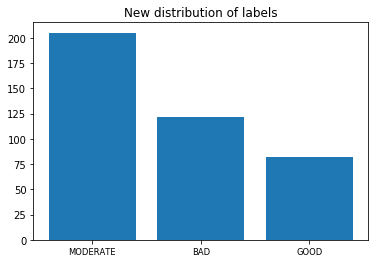

In [19]:
def get_new_label(s):
    if s >= good_threshold: return 'GOOD'
    if s >= moderate_threshold: return 'MODERATE'
    return 'BAD'

project_data['Label'] = project_data['Score'].apply(lambda s: get_new_label(s))
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('New distribution of labels')
plt.show()

In [22]:
# save the new thresholds
data = {}
data['moderate'] = moderate_threshold
data['good'] = good_threshold
filename = '../../../../../src/main/resources/com/sap/sgs/phosphor/fosstars/model/rating/oss/OssSecurityRatingThresholds.json'
with open(filename, 'w') as file:
    json.dump(data, file, sort_keys=True, indent=2)